# American Put numerical Example

Here we implemente the Least Square Monte Carlo alagorithm described in Longstaff, Francis, Eduardo (2001).

We provide examples in pricing American style put options, with an underlying whose price process follows a geometric bronian motion.

We first show a sample optimal stopping decision making process. We then use the algorithm to compute the price for a made-up sample put option as discussed in Moreno, Manuel, Javier (2003). We get slightly different result due to the difference in availbale execution dates setting.

We also try to use the algorithm to price March 2020 S&P 500 at the money American put option, which is most traded in the current market. Simulation result shows consistency with the market traded price of this option.

We majorly focus on power polynomial with 1 and 2 terms, legendre polynomial with 2 terms. Our algorithm is easy to adapt to other basis functions and to including more terms.

## Coding the algorithm

In [1]:
import numpy as np
import pandas as pd
from scipy.special import comb
from sklearn.linear_model import LinearRegression

In [2]:
s = 1
n = 8
r = 0.06
sigma = 0.1
T = 8
r_daily = r / 365
sigma_daily = sigma / 365**0.5

In [3]:
# set attributes for underlying price process simulation
def initiate_path(npath = 8, s = 1, r = 0.06, sigma = 0.1, T = 8, strike = 1.1):
    
    # first day
    path = pd.DataFrame(np.zeros(npath)+s)
    r_daily = r / 365
    sigma_daily = sigma / 365**0.5
    
    # generate data day by day
    for i in range(T):
        day_index = path.shape[1] - 1
        this_day = path.iloc[:,day_index]
        next_day = this_day * np.exp(r_daily - sigma_daily**2 /2 + sigma_daily * np.random.normal(size = npath))
        path = pd.concat([path,next_day], axis = 1)

    # clean dataframe
    path.columns = list(range(T+1))
    path['pay_off_at_maturity'] = strike - path[T]
    path['pay_off_at_maturity'] = path['pay_off_at_maturity'].apply(lambda x: max(x,0))
    path['option value at maturity'] = path['pay_off_at_maturity']
    path['executed on'] = T
    return path

In [4]:
path = initiate_path()
path

,0,1,2,3,4,5,6,7,8,pay_off_at_maturity,option value at maturity,executed on
0,1.0,0.991354,0.987061,0.984422,0.987900,0.984065,0.992569,0.995158,0.996598,0.103402,0.103402,8
1,1.0,1.001648,1.011402,1.015786,1.012167,1.014421,1.026246,1.023345,1.014924,0.085076,0.085076,8
2,1.0,1.011235,1.020061,1.012158,1.007627,1.011172,1.006574,1.004922,0.994782,0.105218,0.105218,8
3,1.0,0.997791,0.997359,0.991687,0.987028,0.992844,0.998920,1.009306,1.007829,0.092171,0.092171,8
4,1.0,1.003945,1.011428,1.017763,1.010067,1.004554,1.005879,1.009486,1.003804,0.096196,0.096196,8
5,1.0,0.994579,0.998988,0.994572,0.993500,0.987758,0.984092,0.986628,0.978821,0.121179,0.121179,8
6,1.0,1.000465,1.012071,1.022378,1.027729,1.033585,1.032208,1.027781,1.020960,0.079040,0.079040,8
7,1.0,1.003065,1.005846,1.004966,0.999962,1.017923,1.025125,1.029549,1.027885,0.072115,0.072115,8


In [5]:
reg = LinearRegression()

# functions to generate polynomial series for different basis
# here we did power polynomial and legendre polynomial
def polynomial_power(n, data):
    result = data
    if n == 1:
        return result.values.reshape(-1, 1)
    for i in range(2,n+1):
        result = pd.concat([result,data**i], axis = 1)
    return result

def polynomial_legendre(n, data):
    def term(n, x):
        big_n = n//2
        dn = 2**(-n)
        fn = 0
        for m in range(big_n+1):
            cm = (-1)**m * comb(n,m) * comb(2*n-2*m, n)
            gm = x**(n-2*m)
            fn += cm*gm
        fn *= dn
        return fn
        
    result = data.apply(lambda x: term(1, x))
    if n == 1:
        return result.values.reshape(-1, 1)
    for i in range(2,n+1):
        new_col = data.apply(lambda x: term(i, x))
        result = pd.concat([result,new_col], axis = 1)
    return result

In [6]:
# function to work out execution path based on LSMC method
# expecting basis and the number of terms to be specified
def process_day_i(i, path = path,  basis = polynomial_power, n = 1, display = True, strike = 1.1):
    
    # function to compound execution value into future value on maturity day, for future comparison
    def update_fv(row):
        if row['if execute']:
            return row['execution value'] * (1+r_daily)**(T-i)
        else:
            return row['option value at maturity']
        
    # fit OLS to model conditional expectation function
    day_i = path[[i,'option value at maturity']]
    day_i = day_i[day_i[i] < strike]
    if day_i.shape[0]==0:
        return 
    x_transform = basis(n=n, data = day_i[i])
    # print('original \n',day_i[i].iloc[:5,])
    # print('transform \n', x_transform.iloc[:5,])
    reg.fit(x_transform, day_i['option value at maturity'])
    if display:
        print('\n day', i, 'ITM path: ', list(day_i.index))
        print('\n conditional expectation function: ', 'intercept: ', reg.intercept_, 'coef: ', reg.coef_)
    
    # generate conditional expectation, make decision on whether to execute or continuue
    day_i['expected continuation value'] = reg.predict(x_transform) * (1/(1+r_daily))
    day_i['execution value'] = day_i[i].apply(lambda x: max(0,strike-x))
    day_i['if execute'] = day_i['execution value'] > day_i['expected continuation value']
    if display:
        print('\n choose to execute on these paths', (day_i[day_i['if execute']==True].index))
    
    # update execution day, option value, into main dataframe
    day_i['updated option value at maturity'] = day_i.apply(update_fv, axis = 1)
    path.loc[day_i.index,'option value at maturity'] = day_i['updated option value at maturity']
    path.loc[day_i[day_i['if execute']==True].index,'executed on'] = i
    

## Backword optimal stopping decision making example

In [7]:
# make decision on full path
for day_i in range(T-1,0,-1):
    process_day_i(day_i)
    display(path)


 day 7 ITM path:  [0, 1, 2, 3, 4, 5, 6, 7]

 conditional expectation function:  intercept:  1.0939393878695778 coef:  [-0.9889866]

 choose to execute on these paths Int64Index([], dtype='int64')


,0,1,2,3,4,5,6,7,8,pay_off_at_maturity,option value at maturity,executed on
0,1.0,0.991354,0.987061,0.984422,0.987900,0.984065,0.992569,0.995158,0.996598,0.103402,0.103402,8
1,1.0,1.001648,1.011402,1.015786,1.012167,1.014421,1.026246,1.023345,1.014924,0.085076,0.085076,8
2,1.0,1.011235,1.020061,1.012158,1.007627,1.011172,1.006574,1.004922,0.994782,0.105218,0.105218,8
3,1.0,0.997791,0.997359,0.991687,0.987028,0.992844,0.998920,1.009306,1.007829,0.092171,0.092171,8
4,1.0,1.003945,1.011428,1.017763,1.010067,1.004554,1.005879,1.009486,1.003804,0.096196,0.096196,8
5,1.0,0.994579,0.998988,0.994572,0.993500,0.987758,0.984092,0.986628,0.978821,0.121179,0.121179,8
6,1.0,1.000465,1.012071,1.022378,1.027729,1.033585,1.032208,1.027781,1.020960,0.079040,0.079040,8
7,1.0,1.003065,1.005846,1.004966,0.999962,1.017923,1.025125,1.029549,1.027885,0.072115,0.072115,8



 day 6 ITM path:  [0, 1, 2, 3, 4, 5, 6, 7]

 conditional expectation function:  intercept:  0.9101236612017741 coef:  [-0.80858583]

 choose to execute on these paths Int64Index([5], dtype='int64')


,0,1,2,3,4,5,6,7,8,pay_off_at_maturity,option value at maturity,executed on
0,1.0,0.991354,0.987061,0.984422,0.987900,0.984065,0.992569,0.995158,0.996598,0.103402,0.103402,8
1,1.0,1.001648,1.011402,1.015786,1.012167,1.014421,1.026246,1.023345,1.014924,0.085076,0.085076,8
2,1.0,1.011235,1.020061,1.012158,1.007627,1.011172,1.006574,1.004922,0.994782,0.105218,0.105218,8
3,1.0,0.997791,0.997359,0.991687,0.987028,0.992844,0.998920,1.009306,1.007829,0.092171,0.092171,8
4,1.0,1.003945,1.011428,1.017763,1.010067,1.004554,1.005879,1.009486,1.003804,0.096196,0.096196,8
5,1.0,0.994579,0.998988,0.994572,0.993500,0.987758,0.984092,0.986628,0.978821,0.121179,0.115946,6
6,1.0,1.000465,1.012071,1.022378,1.027729,1.033585,1.032208,1.027781,1.020960,0.079040,0.079040,8
7,1.0,1.003065,1.005846,1.004966,0.999962,1.017923,1.025125,1.029549,1.027885,0.072115,0.072115,8



 day 5 ITM path:  [0, 1, 2, 3, 4, 5, 6, 7]

 conditional expectation function:  intercept:  0.7392450315816508 coef:  [-0.6418829]

 choose to execute on these paths Int64Index([0, 3, 4, 5], dtype='int64')


,0,1,2,3,4,5,6,7,8,pay_off_at_maturity,option value at maturity,executed on
0,1.0,0.991354,0.987061,0.984422,0.987900,0.984065,0.992569,0.995158,0.996598,0.103402,0.115993,5
1,1.0,1.001648,1.011402,1.015786,1.012167,1.014421,1.026246,1.023345,1.014924,0.085076,0.085076,8
2,1.0,1.011235,1.020061,1.012158,1.007627,1.011172,1.006574,1.004922,0.994782,0.105218,0.105218,8
3,1.0,0.997791,0.997359,0.991687,0.987028,0.992844,0.998920,1.009306,1.007829,0.092171,0.107209,5
4,1.0,1.003945,1.011428,1.017763,1.010067,1.004554,1.005879,1.009486,1.003804,0.096196,0.095493,5
5,1.0,0.994579,0.998988,0.994572,0.993500,0.987758,0.984092,0.986628,0.978821,0.121179,0.112298,5
6,1.0,1.000465,1.012071,1.022378,1.027729,1.033585,1.032208,1.027781,1.020960,0.079040,0.079040,8
7,1.0,1.003065,1.005846,1.004966,0.999962,1.017923,1.025125,1.029549,1.027885,0.072115,0.072115,8



 day 4 ITM path:  [0, 1, 2, 3, 4, 5, 6, 7]

 conditional expectation function:  intercept:  0.8735264619540146 coef:  [-0.77445644]

 choose to execute on these paths Int64Index([0, 3, 5, 7], dtype='int64')


,0,1,2,3,4,5,6,7,8,pay_off_at_maturity,option value at maturity,executed on
0,1.0,0.991354,0.987061,0.984422,0.987900,0.984065,0.992569,0.995158,0.996598,0.103402,0.112174,4
1,1.0,1.001648,1.011402,1.015786,1.012167,1.014421,1.026246,1.023345,1.014924,0.085076,0.085076,8
2,1.0,1.011235,1.020061,1.012158,1.007627,1.011172,1.006574,1.004922,0.994782,0.105218,0.105218,8
3,1.0,0.997791,0.997359,0.991687,0.987028,0.992844,0.998920,1.009306,1.007829,0.092171,0.113046,4
4,1.0,1.003945,1.011428,1.017763,1.010067,1.004554,1.005879,1.009486,1.003804,0.096196,0.095493,5
5,1.0,0.994579,0.998988,0.994572,0.993500,0.987758,0.984092,0.986628,0.978821,0.121179,0.106570,4
6,1.0,1.000465,1.012071,1.022378,1.027729,1.033585,1.032208,1.027781,1.020960,0.079040,0.079040,8
7,1.0,1.003065,1.005846,1.004966,0.999962,1.017923,1.025125,1.029549,1.027885,0.072115,0.100104,4



 day 3 ITM path:  [0, 1, 2, 3, 4, 5, 6, 7]

 conditional expectation function:  intercept:  0.8772929086519928 coef:  [-0.77347466]

 choose to execute on these paths Int64Index([], dtype='int64')


,0,1,2,3,4,5,6,7,8,pay_off_at_maturity,option value at maturity,executed on
0,1.0,0.991354,0.987061,0.984422,0.987900,0.984065,0.992569,0.995158,0.996598,0.103402,0.112174,4
1,1.0,1.001648,1.011402,1.015786,1.012167,1.014421,1.026246,1.023345,1.014924,0.085076,0.085076,8
2,1.0,1.011235,1.020061,1.012158,1.007627,1.011172,1.006574,1.004922,0.994782,0.105218,0.105218,8
3,1.0,0.997791,0.997359,0.991687,0.987028,0.992844,0.998920,1.009306,1.007829,0.092171,0.113046,4
4,1.0,1.003945,1.011428,1.017763,1.010067,1.004554,1.005879,1.009486,1.003804,0.096196,0.095493,5
5,1.0,0.994579,0.998988,0.994572,0.993500,0.987758,0.984092,0.986628,0.978821,0.121179,0.106570,4
6,1.0,1.000465,1.012071,1.022378,1.027729,1.033585,1.032208,1.027781,1.020960,0.079040,0.079040,8
7,1.0,1.003065,1.005846,1.004966,0.999962,1.017923,1.025125,1.029549,1.027885,0.072115,0.100104,4



 day 2 ITM path:  [0, 1, 2, 3, 4, 5, 6, 7]

 conditional expectation function:  intercept:  0.8139963993645697 coef:  [-0.71047948]

 choose to execute on these paths Int64Index([0], dtype='int64')


,0,1,2,3,4,5,6,7,8,pay_off_at_maturity,option value at maturity,executed on
0,1.0,0.991354,0.987061,0.984422,0.987900,0.984065,0.992569,0.995158,0.996598,0.103402,0.113051,2
1,1.0,1.001648,1.011402,1.015786,1.012167,1.014421,1.026246,1.023345,1.014924,0.085076,0.085076,8
2,1.0,1.011235,1.020061,1.012158,1.007627,1.011172,1.006574,1.004922,0.994782,0.105218,0.105218,8
3,1.0,0.997791,0.997359,0.991687,0.987028,0.992844,0.998920,1.009306,1.007829,0.092171,0.113046,4
4,1.0,1.003945,1.011428,1.017763,1.010067,1.004554,1.005879,1.009486,1.003804,0.096196,0.095493,5
5,1.0,0.994579,0.998988,0.994572,0.993500,0.987758,0.984092,0.986628,0.978821,0.121179,0.106570,4
6,1.0,1.000465,1.012071,1.022378,1.027729,1.033585,1.032208,1.027781,1.020960,0.079040,0.079040,8
7,1.0,1.003065,1.005846,1.004966,0.999962,1.017923,1.025125,1.029549,1.027885,0.072115,0.100104,4



 day 1 ITM path:  [0, 1, 2, 3, 4, 5, 6, 7]

 conditional expectation function:  intercept:  0.7482760031941841 coef:  [-0.64824551]

 choose to execute on these paths Int64Index([0, 3, 5], dtype='int64')


,0,1,2,3,4,5,6,7,8,pay_off_at_maturity,option value at maturity,executed on
0,1.0,0.991354,0.987061,0.984422,0.987900,0.984065,0.992569,0.995158,0.996598,0.103402,0.108771,1
1,1.0,1.001648,1.011402,1.015786,1.012167,1.014421,1.026246,1.023345,1.014924,0.085076,0.085076,8
2,1.0,1.011235,1.020061,1.012158,1.007627,1.011172,1.006574,1.004922,0.994782,0.105218,0.105218,8
3,1.0,0.997791,0.997359,0.991687,0.987028,0.992844,0.998920,1.009306,1.007829,0.092171,0.102327,1
4,1.0,1.003945,1.011428,1.017763,1.010067,1.004554,1.005879,1.009486,1.003804,0.096196,0.095493,5
5,1.0,0.994579,0.998988,0.994572,0.993500,0.987758,0.984092,0.986628,0.978821,0.121179,0.105542,1
6,1.0,1.000465,1.012071,1.022378,1.027729,1.033585,1.032208,1.027781,1.020960,0.079040,0.079040,8
7,1.0,1.003065,1.005846,1.004966,0.999962,1.017923,1.025125,1.029549,1.027885,0.072115,0.100104,4


In [8]:
path

,0,1,2,3,4,5,6,7,8,pay_off_at_maturity,option value at maturity,executed on
0,1.0,0.991354,0.987061,0.984422,0.987900,0.984065,0.992569,0.995158,0.996598,0.103402,0.108771,1
1,1.0,1.001648,1.011402,1.015786,1.012167,1.014421,1.026246,1.023345,1.014924,0.085076,0.085076,8
2,1.0,1.011235,1.020061,1.012158,1.007627,1.011172,1.006574,1.004922,0.994782,0.105218,0.105218,8
3,1.0,0.997791,0.997359,0.991687,0.987028,0.992844,0.998920,1.009306,1.007829,0.092171,0.102327,1
4,1.0,1.003945,1.011428,1.017763,1.010067,1.004554,1.005879,1.009486,1.003804,0.096196,0.095493,5
5,1.0,0.994579,0.998988,0.994572,0.993500,0.987758,0.984092,0.986628,0.978821,0.121179,0.105542,1
6,1.0,1.000465,1.012071,1.022378,1.027729,1.033585,1.032208,1.027781,1.020960,0.079040,0.079040,8
7,1.0,1.003065,1.005846,1.004966,0.999962,1.017923,1.025125,1.029549,1.027885,0.072115,0.100104,4


In [24]:
# option value on day 0
print('Simulated price under default setting:')
path['option value at maturity'].mean() * (1+r_daily)**(-T)

Simulated price under default setting:


0.09756799239313535

In [10]:
# wrap the whole process into a function, output option price
def american_option_price(basis = polynomial_power, n = 1, display = False,
                         npath = 1000, s = 1, r = 0.06, sigma = 0.1, T =100, strike = 1.1):
    path = initiate_path(npath = npath,
                         s = s, r = r, sigma = sigma, T = T, strike = strike)
    r_daily = r / 365
    T = path.shape[1]-4
    for day_i in range(T-1,0,-1):
        process_day_i(i = day_i, path = path, basis = basis, n = n, strike = strike,
                      display = False)
        path['option value at maturity'].mean() * (1+r_daily)**(-T)
    if display:
        display(path)
    return (path['option value at maturity'].mean() * (1+r_daily)**(-T))


## Pricing examples

In [34]:
# power polynomial with 1 term
p = american_option_price(basis = polynomial_power, n = 1, strike = 1.05)
print('Option price using 1 term power polynomial baisis:')
print('$', round(p,2))

Option price using 1 term power polynomial baisis:
$ 0.05


In [35]:
# power polynomial with 2 term
p = american_option_price(basis = polynomial_power, n = 2, strike = 1.05)
print('Option price using 2 term power polynomial baisis:')
print('$', round(p,2))

Option price using 2 term power polynomial baisis:
$ 0.05


In [36]:
# legendre polynomial
# legendre polynomial with 1 term is just x itself, so we skip it
p = american_option_price(basis = polynomial_legendre, n = 2, strike = 1.05)
print('Option price using 2 term legendre polynomial baisis:')
print('$', round(p,2))

Option price using 2 term legendre polynomial baisis:
$ 0.05


## Pricing examples, compared with Moreno, Manuel, Javier (2003)

Setting: ATM American put, with strike price of $40, maturing in 1 year, risk free rate 0.06, sigma 0.2

In [37]:
# power polynomial with 1 term
p = american_option_price(basis = polynomial_power, n = 1, display = False,
                         npath = 1000, s = 40, r = 0.06, sigma = 0.2, T =365, strike = 40)
print('Option price using 1 term power polynomial baisis:')
print('$', round(p,2))

Option price using 1 term power polynomial baisis:
$ 2.17


In [49]:
# power polynomial with 2 terms
p = american_option_price(basis = polynomial_power, n = 2, display = False,
                         npath = 1000, s = 40, r = 0.06, sigma = 0.2, T =365, strike = 40)
print('Option price using 2 term power polynomial baisis:')
print('$', round(p,2))

Option price using 2 term power polynomial baisis:
$ 2.32


In [39]:
# legendre polynomial with 2 terms
p = american_option_price(basis = polynomial_legendre, n = 2, display = False,
                         npath = 1000, s = 40, r = 0.06, sigma = 0.2, T =365, strike = 40)
print('Option price using 2 term legendre polynomial baisis:')
print('$', round(p,2))

Option price using 2 term legendre polynomial baisis:
$ 2.36


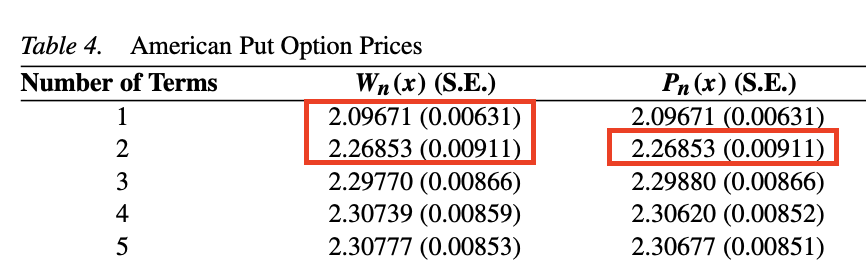

In [48]:
from IPython.display import Image
Image(filename='/Users/Simon-CWG/Pictures/Screenshot/Screen Shot 2020-02-29 at 9.02.00 PM.png',width=800, height=400)

In MMJ(2001), simulated price for these 3 kinds of basis are:
2.09671, 2.26853, 2.26853

We got slightly different result, partly due to the differences in setting. In their paper they assume there are 70 execution day throughout the year. Here we assume it can be executed everyday.

Note that the result is not robust (small variation between simulations). Npath should be increased to improve robustness. However it is set as 1000 here for the sake of computation speed.

The fact that our simulation prices are higher than MMJ's result can be expalined by option pricing intuition: more frequent execution days add value to American option. 

## Pricing example, compared with market quotes

S&P 500 American Put, with specifications as of Feb 29:
    
    maturing at: Mar 20, 2020
    strike price: $2950
current VIX index (used as implied vol): 40.11
currently trading at: $109
    

Other market information needed:
    
    SPX latest close price: 2954.22
    US 1 month bond yield: 1.47%

(more info: https://www.cmegroup.com/trading/equity-index/us-index/e-mini-sandp500_quotes_globex_options.html?optionProductId=138&optionExpiration=138-H0#optionProductId=138&optionExpiration=138-H0&strikeRange=ATM)

In [40]:
# Simulate using 1 term power polynomial
p = american_option_price(basis = polynomial_power, n = 1, display = False,
                         npath = 10000, s = 2954.22, r = 0.0147,
                      sigma = 0.4011, T = 21, strike = 2950)
print('Option price using 1 term power polynomial baisis:')
print('$', round(p,2))

Option price using 1 term power polynomial baisis:
$ 110.65


In [45]:
# Simulate using 2 term power polynomial
p = american_option_price(basis = polynomial_power, n = 2, display = False,
                         npath = 10000, s = 2954.22, r = 0.0147,
                      sigma = 0.4011, T = 21, strike = 2950)
print('Option price using 2 term power polynomial baisis:')
print('$', round(p,2))

Option price using 2 term power polynomial baisis:
$ 110.88


In [46]:
# Simulate using 2 term power polynomial
p = american_option_price(basis = polynomial_legendre, n = 2, display = False,
                         npath = 10000, s = 2954.22, r = 0.0147,
                      sigma = 0.4011, T = 21, strike = 2950)
print('Option price using 2 term legendre polynomial baisis:')
print('$', round(p,2))

Option price using 2 term legendre polynomial baisis:
$ 108.39


Simulated results are close to market price ($109). However more path need to be used to generate more robust simulation results.